In [20]:
import os
import pandas as pd 
import numpy as np 
import subprocess
import math
import pickle

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KernelDensity

from scipy.stats import mannwhitneyu # Read this: https://www.statstutor.ac.uk/resources/uploaded/mannwhitney.pdf
from scipy.special import kl_div

import dataframe_image as dfi

import matplotlib.pyplot as plt 
from matplotlib.patches import Patch
import matplotlib.cm 
import matplotlib.colors 
from matplotlib.gridspec import GridSpec
import seaborn as sns 
plt.rcParams['font.family'] = 'Arial'

from selenobot.files import FASTAFile, GBFFFile, BLASTFile
from selenobot.tools import BLAST
from selenobot.organism import Organism, download_ncbi_data, get_organisms, get_short_species_name
from selenobot.datasets import Dataset 

import re
import glob

%load_ext autoreload 
%autoreload 2

# NOTE: Why does the maximum allowed overlap for Prodigal need to be less than the sequence length?

# Mycobacterium is an intracellular parasite so might have a weird genome.
# Also apparently has lots of leaderless peptides... https://pmc.ncbi.nlm.nih.gov/articles/PMC6028130/ 


# The logic behind the last_10 embeddings falls apart when you consider that many of the truncated selenoproteins are truncated at the N-terminus, 
# not the C-terminus. It also makes sense why training a model on the logits of the EOS token may be a bad idea. 
# 
# I still think it would be useful to interpret the output logits of the ESM embedding, but hard to do that without assuming C-terminal truncation.
# Could possibly add an <unk> token in front of the methionine (and at the end of the sequence), and check the logits of those? I think that might be 
# the right thing to do, but probably keep those separate from the models. 

# This also seems to be a major flaw in the training set. Should augment the truncated selenoprotein set with both C-terminal and N-terminal 
# truncations. Seems like a good idea to add an additional class, as will want some guidance as to which way to extend the sequence. 


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
# os.chdir('../scripts')
# for model_name in os.listdir('../models'):
#     for input_path in glob.glob('../data/model_organisms/*h5'):
#         model_name = model_name.replace('.pkl', '')
#         feature_type = model_name.replace('model_2c_', '').replace('model_3c_', '')
#         subprocess.run(f'python predict.py --input-path {input_path} --model-name {model_name} --feature-type {feature_type}', shell=True, check=True)

In [22]:
species = ['Pseudomonas aeruginosa', 'Escherichia coli', 'Mycobacterium tuberculosis', 'Bacillus subtilis', 'Aliivibrio fischeri'] 
feature_types = ['plm_esm_gap', 'plm_pt5', 'plm_esm_cls'] # , 'plm_esm_log']
start_codons, stop_codons = ['ATG', 'GTG', 'TTG'], ['TAA', 'TAG', 'TGA']

label_map = {'error':'error', 'inter':'error (intergenic)', 'pseudo':'pseudogene', 'rna':'other', 'misc':'other'}

color_map = {'cds':'tab:green', 'error':'tab:red', 'error (intergenic)':'tab:red', 'pseudogene':'tab:blue', 'other':'gray'}
color_map.update({codon:color for codon, color in zip(stop_codons, ['tab:red', 'tab:blue', 'tab:green'])})
color_map.update({codon:color for codon, color in zip(start_codons, ['tab:red', 'tab:blue', 'tab:green'])})
color_map.update({0:'gray', 1:'black'})

labels = list(label_map.values())


In [117]:
organisms_gtdb = get_organisms(species, from_gtdb=True)
organisms = get_organisms(species)

org_df = pd.concat([organism.to_df() for organism in organisms], ignore_index=False)
org_gtdb_df = pd.concat([organism.to_df() for organism in organisms_gtdb], ignore_index=False)

pred_df = pd.concat([pd.read_csv(f'../data/results/{str(organism)}.predict.csv', index_col=0) for organism in organisms])
pred_df = pred_df[[col for col in pred_df.columns if ('prediction' in col)]]
org_df = org_df.merge(pred_df, left_index=True, right_index=True, how='left')

In [24]:
# As a sanity check, I want to make sure all models still identify formate dehydrogenase. 

def table_2(feature_types:list, path:str='../figures/model-orgs-3c-table_2.png'):

    org_sec_df = org_df[org_df.ref_seq.fillna('none').str.contains('U')] # Filter out genes with hits for known selenoproteins. 
    row_index, col_index, values = list(), list(), list()

    feature_types = [f'{n}c_{feature_type}' for n in range(2, 4) for feature_type in feature_types]
    col_index = [(feature_type, terminus)  for feature_type in feature_types for terminus in ['C-terminus', 'N-terminus']] 

    for protein_id, df in org_sec_df.groupby('ref_protein_id'):
        strand = df.strand.iloc[0] # Whether or not the selenoprotein is on the forward or reverse strand. 
        df = df.sort_values('start', ascending=(strand == 1)) 
        row_index += [f'{get_short_species_name(df.species.iloc[0])} {df.ref_product.iloc[0].split(',')[0]}']
        row = []
        for feature_type in feature_types:
            c_terminus_pred, n_terminus_pred = df[f'model_{feature_type}_prediction'].iloc[0], df[f'model_{feature_type}_prediction'].iloc[1]
            row += [c_terminus_pred, n_terminus_pred]
        values += [row]
    table_df = pd.DataFrame(values, columns=pd.MultiIndex.from_tuples(col_index), index=row_index)
    dfi.export(table_df, path)
    return table_df

table_2(feature_types)

2c_plm_esm_gap             \
                                                       C-terminus N-terminus   
P. aeruginosa formate dehydrogenase-N subunit a...              1          0   
E. coli formate dehydrogenase H subunit alpha                   1          0   
E. coli formate dehydrogenase-N subunit alpha                   1          0   
E. coli formate dehydrogenase-N subunit alpha                   1          0   

                                                   2c_plm_pt5             \
                                                   C-terminus N-terminus   
P. aeruginosa formate dehydrogenase-N subunit a...          1          0   
E. coli formate dehydrogenase H subunit alpha               1          0   
E. coli formate dehydrogenase-N subunit alpha               1          0   
E. coli formate dehydrogenase-N subunit alpha               1          0   

                                                   2c_plm_esm_cls             \
                                                       C-terminus N-terminus   
P. aeruginosa formate dehydrogenase-N subunit a...              1          0   
E. coli formate dehydrogenase H subunit alpha                   1          0   
E. coli formate dehydrogenase-N subunit alpha                   1          0   
E. coli formate dehydrogenase-N subunit alpha                   1          0   

                                                   3c_plm_esm_gap             \
                                                       C-terminus N-terminus   
P. aeruginosa formate dehydrogenase-N subunit a...              1          0   
E. coli formate dehydrogenase H subunit alpha                   1          0   
E. coli formate dehydrogenase-N subunit alpha                   1          0   
E. coli formate dehydrogenase-N subunit alpha                   1          0   

                                                   3c_plm_pt5             \
                                                   C-terminus N-terminus   
P. aeruginosa formate dehydrogenase-N subunit a...          1          0   
E. coli formate dehydrogenase H subunit alpha               1          0   
E. coli formate dehydrogenase-N subunit alpha               1          0   
E. coli formate dehydrogenase-N subunit alpha               1          0   

                                                   3c_plm_esm_cls             
                                                       C-terminus N-terminus  
P. aeruginosa formate dehydrogenase-N subunit a...              1          0  
E. coli formate dehydrogenase H subunit alpha                   1          0  
E. coli formate dehydrogenase-N subunit alpha                   1          0  
E. coli formate dehydrogenase-N subunit alpha                   1          0

In [25]:
def table_1(pred_df:pd.DataFrame, path:str='../figures/model-orgs-3c-table_1.png'):
    '''A table displaying the number of predicted selenoproteins for each organism for each model.'''
    col_pattern = 'model_([0-9a-z_]+)_prediction'

    col_index = []
    values = []
    for organism in organisms:
        pred_df = pd.read_csv(f'../data/results/{organism}.predict.csv', index_col=0)
        
        row_index = [re.match(col_pattern, col).group(1) for col in pred_df.columns if (re.match(col_pattern, col) is not None)]
        col_values = list()
        for pred in range(3):
            col_index.append((repr(organism), pred))
            col_values += [[(pred_df[f'model_{feature_type}_prediction'] == pred).sum() for feature_type in row_index]]
        values += col_values
    values = np.array(values).T
    table_df = pd.DataFrame(values, index=row_index, columns=pd.MultiIndex.from_tuples(col_index))

    org_names = [repr(organism) for organism in organisms]
    table_df[('total', 0)] = table_df[[(s, 0) for s in org_names]].sum(axis=1)
    table_df[('total', 1)] = table_df[[(s, 1) for s in org_names]].sum(axis=1)
    table_df[('total', 2)] = table_df[[(s, 2) for s in org_names]].sum(axis=1)
    table_df = table_df.sort_values(('total', 1))

    dfi.export(table_df, path)
    return table_df

table_1(pred_df)

P. aeruginosa             E. coli             M. tuberculosis  \
                           0     1     2       0     1     2               0   
3c_plm_esm_gap          4021    35  1737    3084    37  1627            2676   
3c_plm_pt5              3976    32  1785    3050    46  1652            2705   
3c_plm_esm_cls          3949    60  1784    3067    46  1635            2658   
2c_plm_pt5              5752    41     0    4681    67     0            3988   
2c_plm_esm_gap          5750    43     0    4681    67     0            3963   
2c_plm_esm_cls          5728    65     0    4676    72     0            3951   
3c_len                  3706   355  1732    2878   424  1446            2517   
3c_aa_1mer              3836   672  1285    2408  1145  1195            2919   
2c_aa_1mer              5062   731     0    3606  1142     0            3280   
2c_len                  4618  1175     0    3608  1140     0            3090   

                           B. subtilis             A. fischeri             \
                   1     2           0     1     2           0    1     2   
3c_plm_esm_gap   102  1313        2537    29  1684        2551   38  1285   
3c_plm_pt5       102  1284        2523    26  1701        2499   38  1337   
3c_plm_esm_cls   104  1329        2513    40  1697        2535   41  1298   
2c_plm_pt5       103     0        4208    42     0        3828   46     0   
2c_plm_esm_gap   128     0        4196    54     0        3821   53     0   
2c_plm_esm_cls   140     0        4182    68     0        3811   63     0   
3c_len           343  1231        2375   514  1361        2375  305  1194   
3c_aa_1mer       674   498        1831   619  1800        2110  695  1069   
2c_aa_1mer       811     0        3446   804     0        3029  845     0   
2c_len          1001     0        3022  1228     0        3016  858     0   

                total              
                    0     1     2  
3c_plm_esm_gap  14869   241  7646  
3c_plm_pt5      14753   244  7759  
3c_plm_esm_cls  14722   291  7743  
2c_plm_pt5      22457   299     0  
2c_plm_esm_gap  22411   345     0  
2c_plm_esm_cls  22348   408     0  
3c_len          13851  1941  6964  
3c_aa_1mer      13104  3805  5847  
2c_aa_1mer      18423  4333     0  
2c_len          17354  5402     0

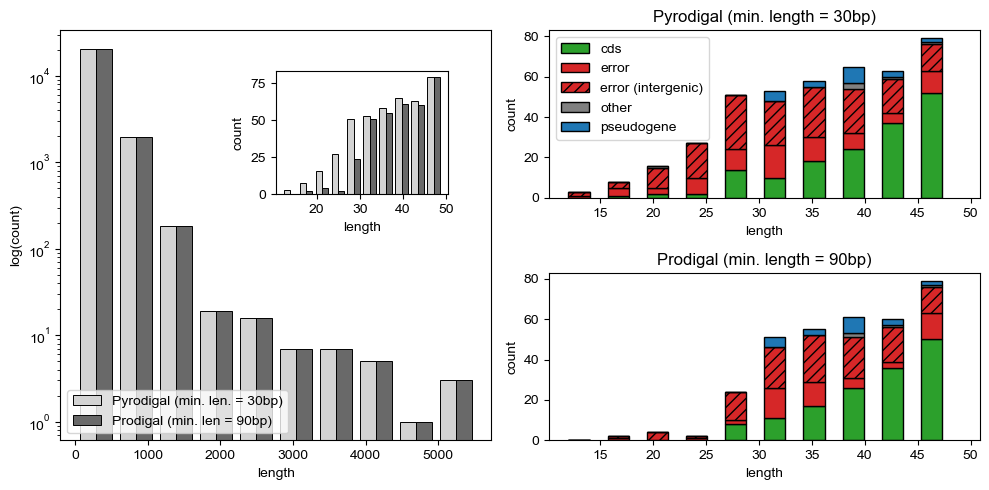

In [26]:

def figure_1(path:str='../figures/model-orgs-3c-figure_1.png'):

    fig = plt.figure(layout='tight', figsize=(10, 5))
    grid = GridSpec(figure=fig, nrows=2, ncols=2)

    ax_a = fig.add_subplot(grid[:, 0])
    ax_b = [fig.add_subplot(grid[0, 1]), fig.add_subplot(grid[1, 1])]

    max_length = 50

    ax_a.hist((org_df.length, org_gtdb_df.length), color=['lightgray', 'dimgray'], edgecolor='black', linewidth=0.7)
    ax_a.legend(['Pyrodigal (min. len. = 30bp)', 'Prodigal (min. len = 90bp)'], loc='lower left')
    ax_a.set_yscale('log')
    ax_a.set_xlabel('length')
    ax_a.set_ylabel('log(count)')

    inset_ax = ax_a.inset_axes((0.5, 0.6, 0.4, 0.3), transform=ax_a.transAxes)
    inset_ax.hist((org_df.length[org_df.length < max_length], org_gtdb_df.length[org_gtdb_df.length < max_length]), color=['lightgray', 'dimgray'], edgecolor='black', linewidth=0.7)
    inset_ax.set_ylabel('count')
    inset_ax.set_xlabel('length')

    hist, bin_edges = np.histogram(org_df.length[org_df.length < max_length])
    for ax, org_df_ in zip(ax_b, [org_df, org_gtdb_df]):
        org_df_.label = org_df_.label.replace(label_map)
        bottom = np.zeros(len(hist))

        for label, df in org_df_.groupby('label'):
            kwargs = {'label':label, 'color':color_map[label], 'edgecolor':'black', 'lw':0.7, 'width':2, 'hatch':'///' if (label == 'error (intergenic)') else None}
            n, _, _ = ax.hist(df.length[df.length < max_length], bins=bin_edges, bottom=bottom, **kwargs)
            bottom += n
        ax.set_xlabel('length')
        ax.set_ylabel('count')

    ax_b[0].set_title('Pyrodigal (min. length = 30bp)')
    ax_b[1].set_title('Prodigal (min. length = 90bp)')
    ax_b[0].legend()

    # NOTE: Prodigal does allow sequences shorter than the minimum if they are partial (run off the end of a contig). 
    plt.show()

figure_1()


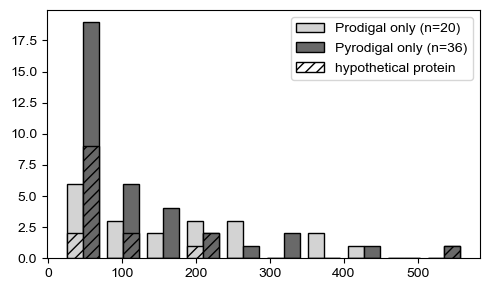

In [27]:
# What genes does Pyrodigal identify that Prodigal does not? 
def figure_2(org_df:pd.DataFrame, org_gtdb_df:pd.DataFrame, path:str='../figures/model-orgs-3c-figure_2.png'):

    if not os.path.exists('model-orgs-3c-figure_2.csv'):
        sources = {'prodigal':org_gtdb_df, 'pyrodigal':org_df}
        ids = {source:df.ref_protein_id[~df.ref_protein_id.isnull()].unique() for source, df in sources.items()}
        ids_shared = np.intersect1d(*list(ids.values())) # Get the IDS which are shared between both

        df = []
        for source, ids_ in ids.items():
            ids_ = ids_[~np.isin(ids_, ids_shared)]
            df_ = sources[source]
            df_ = df_[df_.ref_protein_id.isin(ids_)].assign(source=source)
            df.append(df_)
        df = pd.concat(df, ignore_index=False)
        df.to_csv('model-orgs-3c-figure_2.csv')
    else:
        df = pd.read_csv('model-orgs-3c-figure_2.csv', index_col=0)


    fig, ax = plt.subplots(figsize=(5, 3), layout='tight')

    kwargs = {'edgecolor':'black', 'color':['lightgray', 'dimgray']}
    _, bins, _ = ax.hist([df_.length for _, df_ in df.groupby('source')], **kwargs)
    ax.hist([df_[df_.ref_product.str.contains('hypothetical')].length for _, df_ in df.groupby('source')], hatch='///', bins=bins, **kwargs)
    
    n_prodigal, n_pyrodigal = (df.source == 'prodigal').sum(), (df.source == 'pyrodigal').sum() 
    handles = [Patch(facecolor='lightgray', label=f'Prodigal only (n={n_prodigal})', edgecolor='black')]
    handles += [Patch(facecolor='dimgray', label=f'Pyrodigal only (n={n_pyrodigal})', edgecolor='black')]
    handles += [Patch(facecolor='white', edgecolor='black', hatch='///', label='hypothetical protein')]
    ax.legend(handles=handles)

    plt.show()


figure_2(org_df, org_gtdb_df)


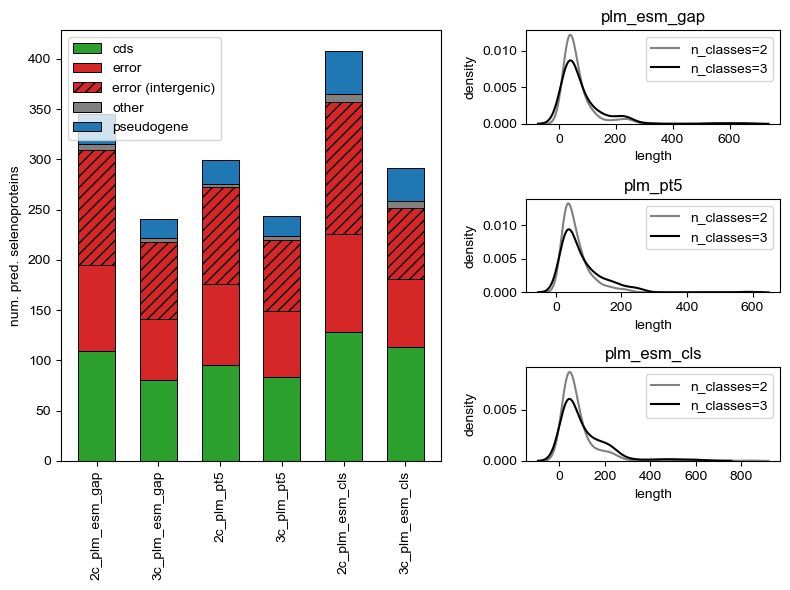

In [29]:
# Want to compare how different models performed on the model organisms... 
# Select feature types based on the results in Table 1. 

def figure_3(org_df:pd.DataFrame, path:str='../figures/model-orgs-3c-figure_3.png', feature_types:list=['plm_esm_gap', 'plm_pt5', 'plm_esm_cls']):

    n_models = 2 * len(feature_types) # Account for 2c- and 3c-models. 

    fig = plt.figure(figsize=(8, len(feature_types) * 2), layout='tight')
    grid = GridSpec(nrows=len(feature_types), ncols=2, figure=fig, width_ratios=[0.6, 0.4])

    ax_a = fig.add_subplot(grid[:, 0])
    ax_b = [fig.add_subplot(grid[i, 1]) for i in range(len(feature_types))]

    bottom = np.zeros(n_models)
    positions = np.arange(n_models)
    model_names = np.ravel([[f'2c_{feature_type}', f'3c_{feature_type}'] for feature_type in feature_types])

    for label, label_df in org_df.groupby('label'):
        heights = [(label_df[f'model_{model_name}_prediction'] == 1).sum() for model_name in model_names]
        kwargs = {'label':label, 'color':color_map[label], 'edgecolor':'black', 'lw':0.7, 'width':0.6, 'hatch':'///' if (label == 'error (intergenic)') else None}
        ax_a.bar(positions, heights, bottom=bottom, **kwargs)
        bottom += np.array(heights)

    ax_a.set_xticks(positions, labels=model_names, ha='center', rotation=90)
    ax_a.set_ylabel('num. pred. selenoproteins')
    ax_a.legend()

    for feature_type, ax in zip(feature_types, ax_b):
        for n_classes, color in {2:'gray', 3:'black'}.items():
            df = org_df[(org_df[f'model_{n_classes}c_{feature_type}_prediction'] == 1)] # Grab the false positives from the DataFrame. 
            sns.kdeplot(df.seq.apply(len), color=color, ax=ax, label=f'n_classes={n_classes}')
        
        ax.set_ylabel('density')
        ax.set_xlabel('length')
        ax.legend()
        ax.set_title(feature_type)

    plt.show()


figure_3(org_df)

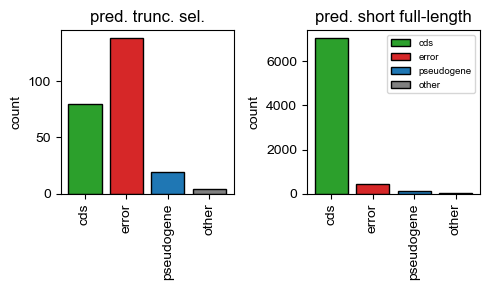

In [40]:
# I also want to get a sense of which proteins are being classified as "short" versus truncated selenoproteins. 
def figure_4(org_df:pd.DataFrame, feature_type:str='plm_esm_gap', path:str=None):

    fig, axes = plt.subplots(ncols=2, layout='tight', figsize=(5, 3))
    preds = [1, 2]
    pred_names = {1:'pred. trunc. sel.', 2:'pred. short full-length'}

    org_df.label = org_df.label.replace({'error':'error', 'inter':'error (intergenic)', 'pseudo':'pseudogene', 'rna':'other', 'misc':'other'}) # Group some of the labels. 
    labels = ['cds', 'error', 'pseudogene', 'other']
    positions = np.arange(len(labels))

    for ax, pred in zip(axes, preds):
        df = org_df[org_df[f'model_3c_{feature_type}_prediction'] == pred]
        heights = [(df.label == label).sum() for label in labels]
        ax.bar(positions, heights, color=[color_map[label] for label in labels], edgecolor='black', label=labels)
        ax.set_xticks(positions, labels=labels, rotation=90)
        ax.set_ylabel('count')
        ax.set_title(pred_names[pred])

    ax.legend(fontsize='x-small')
    
    plt.show()

figure_4(org_df)



In [151]:

def load_organisms_embs(feature_type:str, **kwargs):
    embs_df = []
    for organism in organisms:
        dataset = Dataset.from_hdf(f'../data/model_organisms/gtdb_{str(organism)}.h5', feature_type=feature_type, **kwargs)
        embs_df.append(dataset.to_df(add_metadata=False))
    embs_df = pd.concat(embs_df)
    return embs_df
    

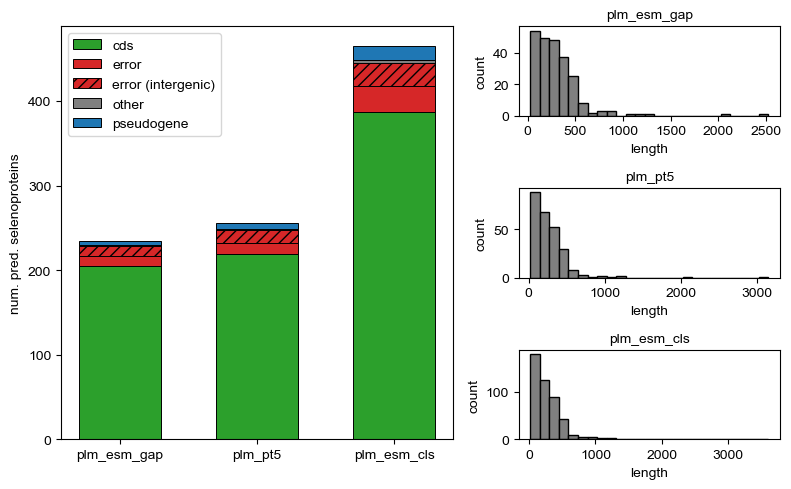

In [56]:
fig = plt.figure(figsize=(8, 5), layout='tight')
grid = GridSpec(nrows=len(feature_types), ncols=2, figure=fig, width_ratios=[0.6, 0.4])

ax_a = fig.add_subplot(grid[:, 0])
ax_b = [fig.add_subplot(grid[i, 1]) for i in range(len(feature_types))]

bottom = np.zeros(len(feature_types))
positions = np.arange(len(feature_types))
for label, label_df in org_df.groupby('label'):
    heights = [(label_df[f'binary_model_{feature_type}_prediction'] == 1).sum() for feature_type in feature_types]
    kwargs = {'label':label, 'color':color_map[label], 'edgecolor':'black', 'lw':0.7, 'width':0.6, 'hatch':'///' if (label == 'error (intergenic)') else None}
    ax_a.bar(positions, heights, bottom=bottom, **kwargs)
    bottom += np.array(heights)

ax_a.set_xticks(positions, labels=feature_types, ha='center')
ax_a.set_ylabel('num. pred. selenoproteins')
ax_a.legend()

for ax, feature_type in zip(ax_b, feature_types):
    lengths = org_df[org_df[f'binary_model_{feature_type}_prediction'] == 1].seq.apply(len)  
    ax.hist(lengths, bins=25, color='gray', edgecolor='black', lw=0.5)
    ax.set_ylabel('count')
    ax.set_xlabel('length')
    ax.set_title(feature_type, fontsize='medium')

plt.tight_layout()
plt.show()

In [101]:
np.sign(0)

np.int64(0)

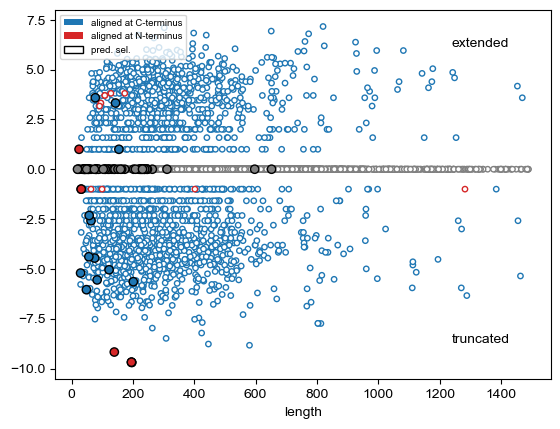

In [115]:
# Many of the coding sequences are, in fact, "truncated", and I want to get a sense of how many. 
def figure_5(org_df:pd.DataFrame, feature_type:str='3c_plm_esm_gap'):
    fig, ax = plt.subplots()

    def color(row):
        if row.n_terminus_aligned and row.c_terminus_aligned:
            return 'gray'
        elif row.n_terminus_aligned:
            return 'tab:red'
        elif row.c_terminus_aligned:
            return 'tab:blue'

    org_df = org_df.copy()[org_df.label == 'cds']
    org_df['start_aligned'] = (org_df.start == org_df.ref_start)
    org_df['stop_aligned'] = (org_df.stop == org_df.ref_stop)
    org_df['c_terminus_aligned'] = (org_df.stop_aligned & (org_df.strand == 1)) | (org_df.start_aligned & (org_df.strand == -1))
    org_df['n_terminus_aligned'] = (org_df.start_aligned & (org_df.strand == 1)) | (org_df.stop_aligned & (org_df.strand == -1))
    org_df['length_diff'] = org_df.length - org_df.ref_length
    org_df['length_diff_adjusted'] = (org_df.length_diff + np.sign(org_df.length_diff)).replace({0:1})
    org_df['log2_length_diff'] = np.sign(org_df.length_diff_adjusted) * np.log2(np.abs(org_df.length_diff_adjusted))
    org_df['color'] = org_df.apply(color, axis=1)
    org_df = org_df.sort_values(by='n_terminus_aligned', ascending=True) # Sort so that N-terminal aligned are plotted last. 
    org_df = org_df[org_df.length < 1500]

    org_1_df = org_df[org_df[f'model_{feature_type}_prediction'] == 1]
    org_0_df = org_df[org_df[f'model_{feature_type}_prediction'] != 1]


    ax.scatter(org_0_df.length, org_0_df.log2_length_diff, edgecolor=org_0_df.color, s=15, color='white') # c='white', edgecolor=org_0_df.color) 
    ax.scatter(org_1_df.length, org_1_df.log2_length_diff, color=org_1_df.color, edgecolors='black') 
    ax.text(0.8, 0.9, 'extended', transform=ax.transAxes) # , fontweight='bold')
    ax.text(0.8, 0.1, 'truncated', transform=ax.transAxes) # , fontweight='bold')
    handles = [Patch(facecolor='tab:blue', label='aligned at C-terminus'), Patch(facecolor='tab:red', label='aligned at N-terminus'), Patch(facecolor='white', edgecolor='black', label='pred. sel.')]
    ax.legend(handles=handles, loc='upper left', fontsize='x-small')
    ax.set_xlabel('length')

    plt.show()

figure_5(org_df)



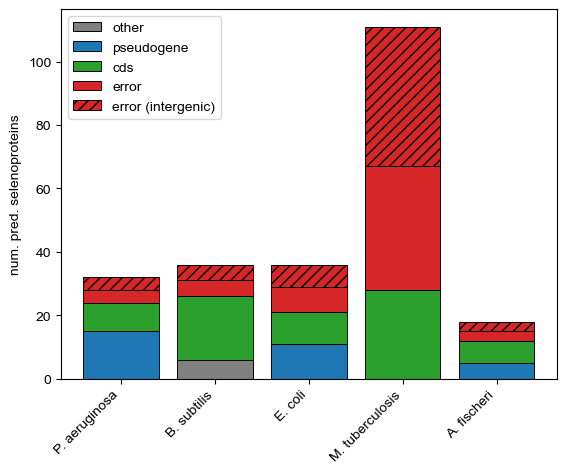

In [10]:
fig, ax = plt.subplots()

species = list(genome_ids.keys()) 

bottom = np.zeros(len(species))
for label in ['other', 'pseudogene', 'cds', 'error', 'error (intergenic)']:
    label_df = org_df[(org_df.label == label) & (org_df[pred_col] == 1)]
    # label_df = pd.concat([organism.to_df(label=label) for organism in organisms])
    heights = np.array([(label_df.species == s).sum() for s in species])
    ax.bar(np.arange(len(organisms)), heights, bottom=bottom, color=color_map[label], edgecolor='black', linewidth=0.7, hatch='///' if (label == 'error (intergenic)') else None)
    bottom += heights

ax.set_xticks(np.arange(len(organisms)), labels=[repr(organism) for organism in organisms], rotation=45, ha='right')
ax.legend(['other', 'pseudogene', 'cds', 'error', 'error (intergenic)'])
# ax.set_yscale('log')
ax.set_ylabel('num. pred. selenoproteins')
plt.show()


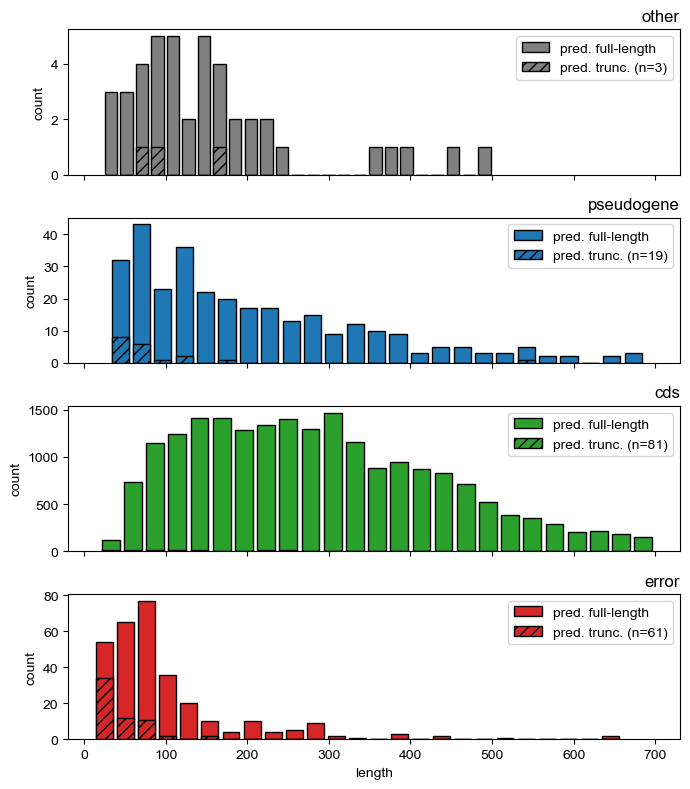

In [ ]:


def figure_4(org_df:pd.DataFrame, max_seq_length:int=700, feature_type:str='3c_plm_esm_gap'):

    fig, axes = plt.subplots(nrows=4, figsize=(7, 8), sharex=True, layout='tight')
    pred_col = f'model_{feature_type}_prediction'

    org_df.label = org_df.label.replace({'inter':'error (intergenic)', 'pseudo':'pseudogene', 'rna':'other', 'misc':'other'}) # Group some of the labels. 
    org_1_df = org_df[org_df[pred_col] == 1]

    for ax, label in zip(axes, ['other', 'pseudogene', 'cds', 'error']):
        lengths = org_df[org_df.label == label].seq.apply(len)
        _, bin_edges, _, = ax.hist(lengths[lengths < max_seq_length], color=color_map[label], bins=25, rwidth=0.8, edgecolor='black')

        lengths = org_1_df[org_1_df.label == label].seq.apply(len) # Look only at the lengths of the predicted selenoproteins. 
        ax.hist(lengths[lengths < max_seq_length], color=color_map[label], bins=bin_edges, rwidth=0.8, edgecolor='black', hatch='///')

        ax.set_ylabel('count')
        ax.set_title(label, loc='right')
        ax.legend(['pred. full-length', f'pred. trunc. (n={len(org_1_df[org_1_df.label == label])})'])

    ax.set_xlabel('length')
    plt.show()

figure_4(org_df)


# I am really curious as to why so many of the short peptides are tagged as full-length... what characteristics of the
# false positives make them false positives, other than length? It seems as though the error sequences are slightly 
# more prone to this problem, though I wonder how much of this effect is due to the fact that the error sequences tend 
# to be shorter. 

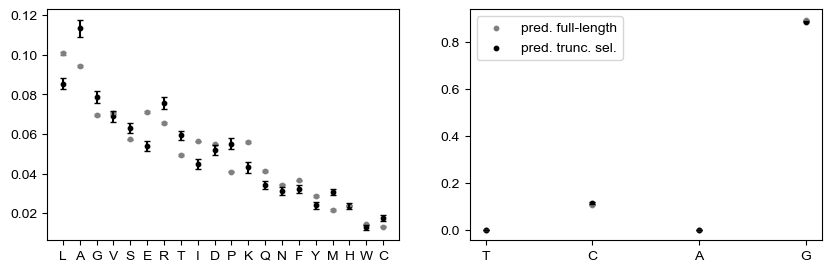

In [85]:
# First going to take a look at the spurious short sequences... what causes them to be flagged?
org_df = load_organisms_df(max_seq_length=200)
# Differences in GC content could signal differences in amino acid composition?
amino_acids = list('LAGVSERTIDPKQNFYMHWC')
bases = list('ACTG')

# From https://www.ncbi.nlm.nih.gov/Taxonomy/Utils/wprintgc.cgi?chapter=cgencodes#SG1
code_map = {'T':list('FFLLSSSSYY**CC*W'), 'C':list('LLLLPPPPHHQQRRRR'), 'A':list('IIIMTTTTNNKKSSRR'), 'G':list('VVVVAAAADDEEGGGG')}
# From https://www.imgt.org/IMGTeducation/Aide-memoire/_UK/aminoacids/IMGTclasses.html
chem_map = {'alipathic':list('AGILPV'), 'aromatic':list('FWY'), 'sulfur':list('CX'), 'hydroxyl':list('ST'), 'basic':list('RHK'), 'acidic':list('DE'), 'amine':list('NQ')}
charge_map = {'positive':list('RHK'), 'negative':list('DE'), 'uncharged':list('ANCQGILMFPSTWYV')}
polar_map = {'polar':list('RNDQEHKSTY'), 'nonpolar':list('ACGILMFPWV')}

n = 50

def apply_map(seq:str, map_=dict):
    inv_map = dict()
    for key, vals in map_.items(): # Invert the map for substitution. 
        inv_map.update({val:key for val in vals})
    for a, b in inv_map.items():
        seq = seq.replace(a, b)
    return seq

x = np.arange(len(amino_acids))

fig, axes = plt.subplots(ncols=2, figsize=(10, 3))

kwargs = {'capsize':2, 'fmt':'none'}
color_map[0] = 'gray'
color_map[1] = 'black'

ax = axes[0]
for pred, df_ in org_df.groupby(pred_col):
    comps_df = pd.DataFrame([{aa:seq[-n:].count(aa) / len(seq[-n:]) for aa in amino_acids} for seq in df_.seq])
    ax.errorbar(x, comps_df.mean(axis=0), yerr=comps_df.std(axis=0) / np.sqrt(len(comps_df)), c=color_map[pred], **kwargs)
    ax.scatter(x, comps_df.mean(axis=0), c=color_map[pred], s=10)
ax.set_xticks(x, labels=amino_acids)

ax = axes[1]

map_  = code_map
cats = list(map_.keys())
x = np.arange(len(map_))

for pred, df_ in org_df.groupby(pred_col):
    seqs = [apply_map(seq, map_) for seq in df_.seq]
    comps_df = pd.DataFrame([{cat:seq[-n:].count(cat) / len(seq[-n:]) for cat in cats} for seq in seqs])
    ax.errorbar(x, comps_df.mean(axis=0), yerr=comps_df.std(axis=0) / np.sqrt(len(comps_df)), c=color_map[pred], **kwargs)
    ax.scatter(x, comps_df.mean(axis=0), c=color_map[pred], s=10)
ax.set_xticks(x, labels=cats)


ax.legend(['pred. full-length', 'pred. trunc. sel.'])

plt.show()

In [19]:
# Another thing to try is to BLAST align the positive predictions with the truncated selenoproteins. 

subj_fasta_file = FASTAFile('blast_subject.fa') # All truncated selenoproteins in the training, testing, and validation datasets.
quer_fasta_file = FASTAFile('blast_query.fa') # All model organism sequences shorter than 200 amino acids in length. 
print('Number of query sequences:', len(quer_fasta_file))
print('Number of subject sequences:', len(subj_fasta_file))

# blast = BLAST()
# blast.run('blast_query.fa', 'blast_subject.fa', output_path='blast_output.tsv', make_database=False, max_high_scoring_pairs=1)

Number of query sequences: 7539
Number of subject sequences: 5810


In [ ]:
org_df = load_organisms_df(max_seq_length=200)
blast_df = BLASTFile('blast_output.tsv').to_df()

blast_n_hits = blast_df[blast_df.e_value < 1e-4].groupby('query_id').apply(len, include_groups=False)
outliers = blast_n_hits.sort_values(ascending=False)[blast_n_hits > 499].index 

# org_df[org_df.index.isin(outliers)][pred_col]


BLASTFile.load_chunks: Loading BLAST output in batches...: 100%|██████████| 151/151 [00:00<00:00, 379.36it/s]


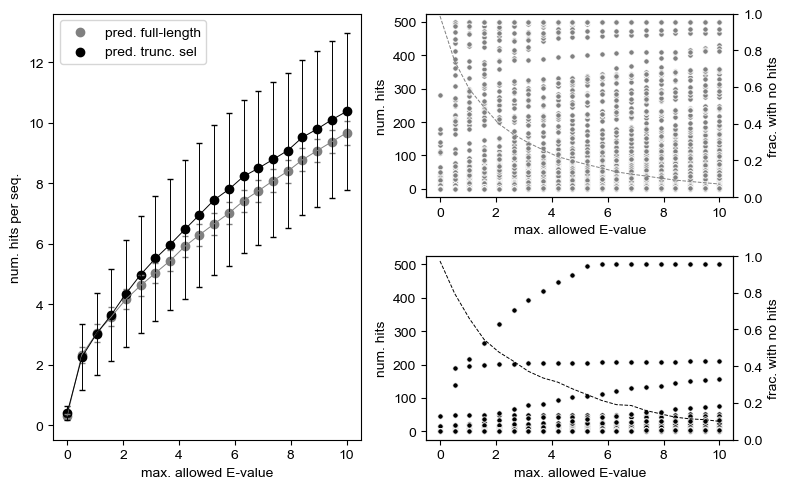

In [ ]:
fig = plt.figure(layout='tight', figsize=(8, 5))
grid = GridSpec(nrows=2, ncols=2, figure=fig)

ax_a = fig.add_subplot(grid[:, 0])
ax_b = [fig.add_subplot(grid[0, 1]), fig.add_subplot(grid[1, 1])]

# Remove the outliers... 
org_df = org_df[~org_df.index.isin(outliers)]

for pred, df in org_df.groupby(pred_col):
    x, y, y_err = list(), list(), list()
    for e in np.linspace(1e-4, blast_df.e_value.max(), 20):
        blast_n_hits = blast_df[blast_df.e_value < e].groupby('query_id').apply(len, include_groups=False)
        blast_n_hits.name = 'blast_n_hits'
        e_df = df.merge(blast_n_hits, left_index=True, right_index=True, how='left')
        e_df.blast_n_hits = e_df.blast_n_hits.fillna(0)

        y.append(e_df.blast_n_hits.mean())
        y_err.append(e_df.blast_n_hits.std() / np.sqrt(len(e_df)))
        x.append(e)

    ax_a.scatter(x, y, c=color_map[pred])
    ax_a.errorbar(x, y, yerr=y_err, c=color_map[pred], capsize=2, lw=0.7)

ax_a.legend(['pred. full-length', 'pred. trunc. sel'])
ax_a.set_xlabel('max. allowed E-value')
ax_a.set_ylabel('num. hits per seq.')

for ax, (pred, df) in zip(ax_b, org_df.groupby(pred_col)):
    x1, y1, x2, y2 = list(), list(), list(), list()
    for e in np.linspace(1e-4, blast_df.e_value.max(), 20):
        blast_n_hits = blast_df[blast_df.e_value < e].groupby('query_id').apply(len, include_groups=False)
        blast_n_hits.name = 'blast_n_hits'
        e_df = df.merge(blast_n_hits, left_index=True, right_index=True, how='left')
        e_df.blast_n_hits = e_df.blast_n_hits.fillna(0)

        x1 += [e] * len(e_df)
        y1 += e_df.blast_n_hits.values.tolist()
        x2 += [e]
        y2 += [(e_df.blast_n_hits == 0).sum() / len(e_df)]

    ax.scatter(x1, y1, s=15, edgecolors='white', lw=0.6, c=color_map[pred])
    ax.set_ylabel('num. hits')
    ax.set_xlabel('max. allowed E-value')

    right_ax = ax.twinx()
    right_ax.plot(x2, y2, color=color_map[pred], lw=0.7, ls='--')
    right_ax.set_ylabel('frac. with no hits')
    right_ax.set_ylim(0, 1)

plt.show()





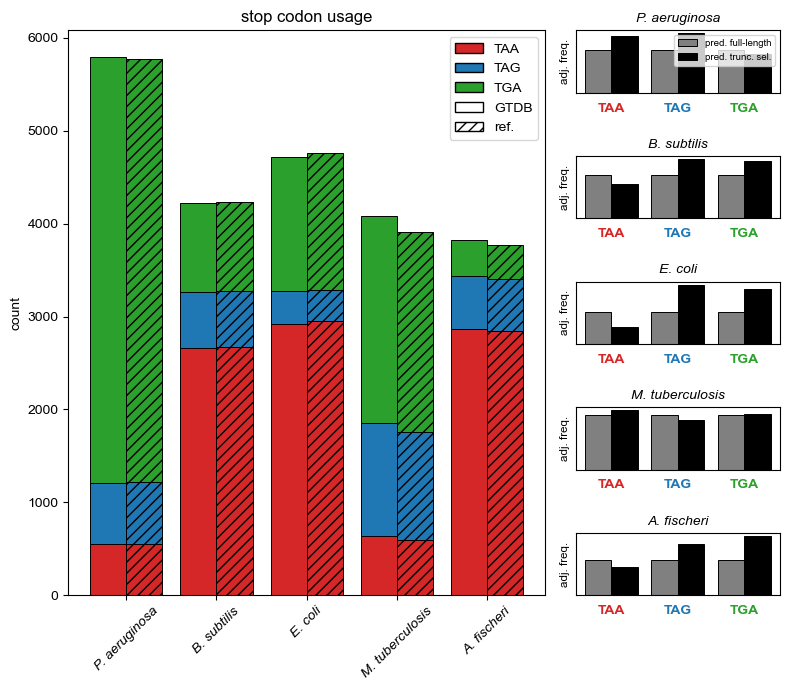

In [89]:
fig = plt.figure(layout='tight', figsize=(8, 7))
grid = GridSpec(nrows=5, ncols=2, figure=fig, width_ratios=[0.7, 0.3])

ax_a = fig.add_subplot(grid[:, 0])
ax_b = [fig.add_subplot(grid[i, 1]) for i in range(5)]

start

def figure_5(codon_type:str='start'):

    codons = {'start':['ATG', 'GTG', 'TTG'], 'stop':['TAA', 'TAG', 'TGA']}
    codons = codons[codon_type]

    df = pd.concat([organism.df.value_counts(f'{codon_type}_codon').sort_index() for organism in organisms], axis=1)
    df = df[~(df.index == 'none')]

    ref_df = pd.concat([organism.ref_df[organism.ref_df.feature == 'CDS'].value_counts('stop_codon').sort_index() for organism in organisms], axis=1)
    ref_df = ref_df[~(ref_df.index == 'none')]

    def add_bar(heights:np.ndarray=None, bottom:np.ndarray=None, ax:plt.Axes=None, offset:float=0, positions:np.ndarray=None, **kwargs):
        ax.bar(positions - offset, heights, bottom=bottom, edgecolor='black', lw=0.7, width=0.4, **kwargs)
        if bottom is not None:
            return bottom + heights

    def add_colored_xtick_labels(ticks:np.ndarray, labels:list=None, colors:list=None, ax:plt.Axes=None, **kwargs):
        ax.set_xticks([])
        for x, label, color in zip(ticks, labels, colors):
            ax.text(x, -0.3, label, color=color, ha='center', transform=ax.get_xaxis_transform(), **kwargs)

    positions = np.arange(len(organisms))
    bottom = np.zeros(len(organisms))
    for codon, heights in zip(df.index, df.values):
        bottom = add_bar(positions=positions, bottom=bottom, heights=heights, ax=ax_a, offset=0.2, color=color_map[codon])

    bottom = np.zeros(len(organisms))
    for codon, heights in zip(ref_df.index, ref_df.values):
        bottom = add_bar(positions=positions, bottom=bottom, heights=heights, ax=ax_a, offset=-0.2, color=color_map[codon], hatch='///')

    handles = [Patch(facecolor=color_map[codon], edgecolor='black') for codon in codons] + [Patch(facecolor='white', edgecolor='black'), Patch(facecolor='white', hatch='///', edgecolor='black')]
    ax_a.legend(handles=handles, labels=codons + ['GTDB', 'ref.'])
    ax_a.set_xticks(positions, labels=[repr(organism) for organism in organisms], rotation=45, fontstyle='italic')
    ax_a.set_title(f'{codon_type} codon usage')
    ax_a.set_ylabel('count')

    positions = np.arange(len(codons))

    for ax, organism in zip(ax_b, organisms):
        ax.set_title(repr(organism), fontsize='medium', fontstyle='italic')
        ax.set_ylabel('adj. freq.', fontsize='small')
        ax.set_yticks([])
        add_colored_xtick_labels(positions, labels=codons, colors=[color_map[codon] for codon in codons], fontweight='bold', fontsize='medium', ax=ax)

        org_df = load_organisms_df(organisms=[organism])
        totals = {codon:(org_df[f'{codon_type}_codon'] == codon).sum() for codon in codons}

        for pred, df in org_df.groupby(pred_col):
            heights = np.array([(df[f'{codon_type}_codon'] == codon).sum() / totals[codon] for codon in codons]) / len(df) 
            add_bar(positions=positions, heights=heights, ax=ax, color=color_map[pred], offset=0.2 if (pred == 0) else -0.2)
    ax_b[0].legend(['pred. full-length', 'pred. trunc. sel.'], fontsize='x-small')

    plt.show()

figure_5(codon_type='stop')

In [25]:
# What if we just look at stop codon usage in the errors? Compare those which are predicted selenoproteins versus not. 
# I'm not sure if we can avoid separating by organism, as it could be skewed by the stop codon usage in different organisms, 
# and the fact that some organisms just have more predicted selenoproteins for a non-stop codon related reason. OR, it could 
# be that the reason some organisms have more predicted selenoproteins is due to their increased UGA stop codon usage. 

# org_df = load_organisms_df(labels=['error', 'error (intergenic)'])
# for pred, df in org_df.groupby(pred_col):
#     # Why do so many of these not have a valid stop or start codon? Ah I am messing up the strand somehow. 
#     print(pred)
#     print(df.value_counts('stop_codon') / len(df))

# org_df = load_organisms_df(labels=['cds'])
# for pred, df in org_df.groupby(pred_col):
#     # Why do so many of these not have a valid stop or start codon? Ah I am messing up the strand somehow. 
#     print(pred)
#     print(df.value_counts('stop_codon') / len(df))

In [49]:
# Last thing I can think of to do is look at the logits for the predicted selenoproteins. 

def softmax(row):
    row = np.exp(row - np.max(row))
    return row / row.sum()

org_df = load_organisms_df(max_seq_length=200) # Load only short sequences...

# Debating what the best way to pre-process this data is. Logits are just the unnormalized model outputs. 
# Options are to apply a softmax and trat the outputs as you would a classifier (look at the probabilities). 
# For this, need to additionally apply a log scale; even after removing the EOS token, the probabilities of the
# different amino acids still varies too wildly to get much of a signal. By standardizing it (which is what 
# happens when I preprocess it for model training), I am basically looking at how far the output is from that
# of other sequences in the short subset, i.e. how many standard deviations from the mean. I think this might be 
# the right call. 

embs = load_organisms_embs(feature_type='plm_esm_log', aa_tokens_only=True)
embs = pd.DataFrame(StandardScaler().fit_transform(embs.values), index=embs.index, columns=Dataset.aa_tokens)
embs, org_df = embs.align(org_df, join='inner', axis=0) # This will basically filter by length. I think I want to do this after standardizing.  

embs_1 = embs[org_df[pred_col] == 1].copy()# .iloc[:, 1:]
embs_0 = embs[org_df[pred_col] == 0].copy() # .iloc[:, 1:]


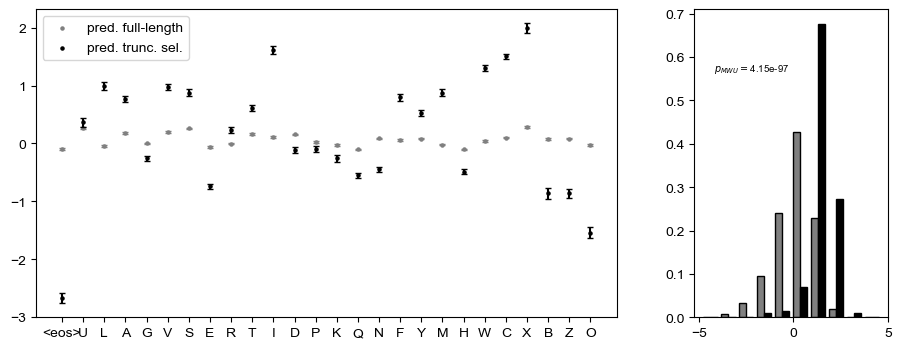

In [52]:
fig, axes = plt.subplots(ncols=2, figsize=(11, 4), width_ratios=[0.75, 0.25])

ax = axes[0]
# x = np.arange(len(Dataset.aa_tokens[1:]))
x = np.arange(len(embs.columns))
for pred, embs_ in enumerate([embs_0, embs_1]):
    # embs_ = embs_.iloc[:, 1:] # Remove the EOS token signal.
    y = embs_.mean(axis=0)
    y_err = embs_.std(axis=0) / np.sqrt(len(embs_))
    ax.scatter(x, y, c=color_map[pred], s=5)
    ax.errorbar(x, y, yerr=y_err, capsize=2, linestyle='', color=color_map[pred])
# ax.set_xticks(x, Dataset.aa_tokens[1:])
ax.set_xticks(x, embs.columns)
ax.legend(['pred. full-length', 'pred. trunc. sel.'])


ax = axes[1]
# I wonder if there is any signal for selenocysteine? Look at the distribution of probability differences for each residue, maybe. 
# Maybe should look how far the output for U is from the mean?

# NOTE: Not sure if this is the right thing to do here, maybe look at the raw output instead? I wanted to control for the fact
# that probabilities for non-EOS tokens are generally higher in the predicted selenoprotein case due to differences in the EOS token prediction. 

# TODO: Find out if ESM is trained with selenocysteines in the dataset, or are these masked? I know that rare amino acids, U included, are masked with X
# in the Prot-T5 model, but can't find anything about ESM. 

def get_dist(aa:str, embs:pd.DataFrame):
    aa_idx = list(embs.columns).index(aa) # Get the amino acid column index. Includes the EOS token
    # This value should be more positive if the predicted residue probability is higher. 
    # dist = np.array([emb[aa_idx] - emb[1:].mean() for emb in embs.values]) # Don't include EOS token in the mean. 
    dist = np.array([emb[aa_idx] for emb in embs.values]) # Don't include EOS token in the mean. 
    return dist

def get_mwu(aa:str, embs:list):
    # Expect the first distribution in the list to be the full-length distribution. 
    dists = [get_dist(aa, embs_) for embs_ in embs]
    res = mannwhitneyu(*dists, alternative='less')
    return res, {'aa':aa, 'p':res.pvalue, 'u':res.statistic}

# Could apply a either KL divergence or Mann-Whitney U, both of which work in non-parametric cases.
# alternative='less' means testing if the first distribution X is less than the second distribution Y.
aa = 'C'
dists = [get_dist(aa, embs_0), get_dist(aa, embs_1)]
res, _ = get_mwu(aa, [embs_0, embs_1])
ax.hist(dists, density=True, color=['gray', 'black'], edgecolor='black')
ax.text(0.1, 0.8, '$p_{MWU}=$' + f'{res.pvalue:.2e}', transform=ax.transAxes, fontsize='x-small')

plt.show()

# NOTE: Honestly seems strange to me that a model based on the logits isn't doing better than it is...

In [47]:
df = pd.DataFrame([get_mwu(aa, [embs_0, embs_1])[1] for aa in embs.columns]).set_index('aa')

In [48]:
df.sort_values('p')

,p,u
aa,,
C,4.151287e-97,149425.0
X,1.642193e-70,251044.0
I,8.898458e-69,258303.0
W,9.048878e-63,284208.0
L,2.801693e-46,362745.0
M,3.626419e-38,406767.0
V,5.816651e-35,425497.0
F,5.637711e-28,469729.0
S,6.873523e-25,491126.0
